# HSKA AI-Lab RL: Deep Q-Learning

## Mount Google Drive as folder

In [7]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/My\ Drive/ai-lab

## Deep Q-Learning

In dem vorherigen Notebook wurde für die Verwendung mit dem Q-Learning Algorithmus der State-Space diskretisiert, um die Komplexität zu reduzieren. In dieser Aufgabe soll nun der State-Space unverändert in der Q-Funktion abgebildet werden, ohne Informationen zu verwerfen. Dafür soll Q-Learning so erweitert werden, dass die Q-Funktion mithilfe eines neuronalen Netzes trainiert werden kann. Wie in Aufgabe 2, soll dies zunächst anhand des Beispiels [CartPole](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) implementiert werden. Zur Wiederholung: CartPole steht im OpenAI Gym zur Verfügung und wird in der Implementierung (`CartPoleEnv`) wie folgt beschrieben:

```python
"""
A pole is attached by an un-actuated joint to a cart, which moves along
a frictionless track. The pendulum starts upright, and the goal is to
prevent it from falling over by increasing and reducing the cart's
velocity.
"""
```

### CartPole Environment vorbereiten

In [8]:
%pip install --upgrade pip
%pip install tensorflow
%pip install 'gym[atari]==0.12.5'
%pip install pyglet==1.3.2
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:

import gym

import random
from collections import deque
from operator import itemgetter
from typing import Tuple
import time
from contextlib import suppress

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, multiply
from keras import Input, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

from plot_utils import plot_statistics
import check_test
from abstract_agent import AbstractAgent

!apt-get install -y xvfb python-opengl
%pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

zsh:1: command not found: apt-get
Note: you may need to restart the kernel to use updated packages.


In [10]:
env = gym.make('CartPole-v0')
env.seed(42)

[42]

### Aufgabe 3.1: Deep Q-Learning mit CartPole

Im ersten Schritt zu einem vollwertigen Deep Reinforcement Learning Agent soll die bisher in Form einer Tabelle abgebildete Q-Funktion durch ein neuronales Netz ersetzt werden. Für die Implementierung des Netzes wird Keras mit einem TensorFlow Backend verwendet. Das entsprechende Model (siehe `build_model`) ist dabei bereits vorgegeben und muss nicht selbst implementiert werden. Dieses besteht aus zwei vollverknüpften Hidden Layer und einem entsprechenden Ein- und Ausgangs-Layer. Wie im Rahmen der theoretischen Einführung gezeigt, werden aus Performance-Gründen Action-Values für jede Action nur anhand des States berechnet. Das bedeutet, dass der Input des Netzes entsprechend aus den Feature (= State) besteht und der Ausgang aus den möglichen Actions. Die in dem jeweiligen State gewählte Action wird im Ausgang maskiert, sodass nur diese "aktiviert" (mit 1.0 multipliziert) wird und die anderen Actions entsprechend auf 0.0 gesetzt werden.

In [13]:
def build_model(state_size: int, action_size: int, alpha: float):
    # With the functional API we need to define the inputs.
    # Sequential API no longer works because of merge mask
    states_input = Input((state_size,), name='states')
    action_mask = Input((action_size,), name='action_mask')

    hidden_1 = Dense(units=32, activation='relu')(states_input)
    hidden_2 = Dense(units=32, activation='relu')(hidden_1)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = Dense(action_size, activation='linear')(hidden_2)

    # Finally, we multiply the output by the mask!
    # The main drawback of [passing the action as an input] is that a separate forward pass is required
    # to compute the Q-value of each action, resulting in a cost that scales linearly with the number of
    # actions. We instead use an architecture in which there is a separate output unit for each possible
    # action, and only the state representation is an input to the neural network.
    # The outputs correspond to the predicted Q-values of the individual action for the input state.
    # The main advantage of this type of architecture is the ability to compute Q-values for
    # all possible actions in a given state with only a single forward pass through the network.
    filtered_output = multiply([output, action_mask])

    model = Model(inputs=[states_input, action_mask], outputs=filtered_output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=alpha), metrics=None)

    return model

#### Aufbau Keras Model

Nachfolgend wird zur Verdeutlichung des Keras Modells dieses nochmal geplottet.

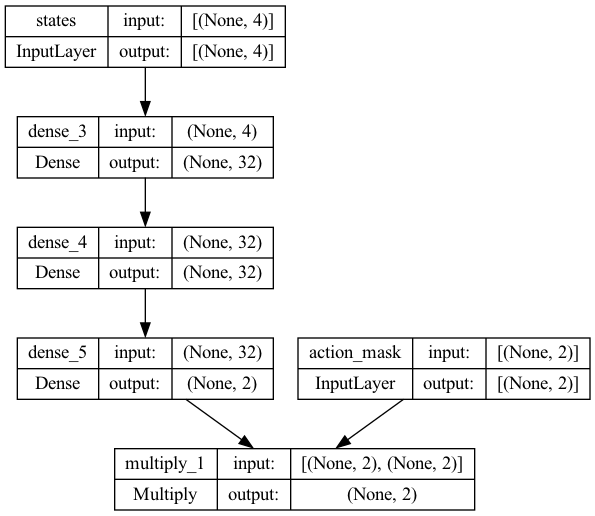

In [14]:
model = build_model(state_size=env.observation_space.shape[0],
                    action_size=env.action_space.n,
                    alpha=0.001)

tf.keras.utils.plot_model(model, to_file='keras_plot_model.png', show_shapes=True)
display.Image('keras_plot_model.png')

#### Deep Q-Learning Agent

Für den `AdvancedQAgent`, welcher wieder von `AbstractAgent` erbt, muss zu den bisherigen Methoden `act` und `train` (`__init__` ist hier bereits vorgegeben) noch die private Methode `_replay` implementiert werden. Der Agent besitzt eine Art Gedächtnis (siehe `memory` in der `__init__` Methode), welches als Ring-Buffer implementiert ist. Dieses Gedächtnis dient dazu, beobachtete States zu persistieren, um diese Erfahrungen dann als Mini-Batch beim Lernen an den Optimizer des neuronalen Netzes zu schicken. Die Größe des Gedächtnisses entspricht der eines Mini-Batches. In der `_replay` Methode werden die States aus dem Gedächtnis ausgelesen, um die Q-Funktion zu updaten.

Der `AdvancedQAgent` entspricht dabei noch nicht der Implementierung des in der theoretischen Einführung vorgestelltem Deep Q-Network. In diesem ersten naiven Ansatz, wird das Gedächtnis noch nicht im Sinne des im [Paper von DeepMind](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) gezeigten Replay Memory eingesetzt, sondern lediglich als Speicher für das Sammeln von Erfahrungen für das Batch-Update. Auch gibt es in diesem ersten Ansatz noch kein Target Network.

In [75]:
class AdvancedQAgent(AbstractAgent):

    def __init__(self, action_size: int, state_size: int, model: Model, batch_size: int, 
                 gamma: float, epsilon: float, epsilon_decay: float, epsilon_min: float):
        self.action_size = action_size
        self.state_size = state_size
        
        self.gamma = gamma # discount factor (how much discount future reward)
        self.epsilon = epsilon # initial exploration rate of the agent (exploitation vs. exploration)
        self.epsilon_min = epsilon_min # minimal epsilon: x% of the time take random action
        self.epsilon_decay = epsilon_decay # decay epsilon over time to shift from exploration to exploitation
        
        self.step = 0 # number of steps played
        
        # Remembered states and rewards which are used for learning in mini-batch volumes
        self.memory = deque(maxlen=batch_size)
        
        self.model = model
        self.batch_size = batch_size # can be any multiple of 32 (smaller mini-batch size usually leads to higher accuracy)

        self.action_mask = np.ones((1, self.action_size))
        self.action_mask_batch = np.ones((self.batch_size, self.action_size))

    def _replay(self) -> None:
        """Gets collected experiences from memory for batch update of Q-function.
        
        Returns:
            None
        """
        # TODO: Get mini-batch from memory and create numpy arrays for each part of this experience
        states, actions, next_states, rewards, dones = [np.array(memory) for memory in zip(*self.memory)]
        
        # The following assert statements are intended to support further implementation,
        # but can also be removed/adjusted if necessary
        assert all(isinstance(x, np.ndarray) for x in (states, actions, rewards, next_states, dones)), \
            "All experience batches should be of type np.ndarray."
        assert states.shape == (self.batch_size, self.state_size), \
            f"States shape should be: {(self.batch_size, self.state_size)}"
        assert actions.shape == (self.batch_size,), f"Actions shape should be: {(self.batch_size,)}"
        assert rewards.shape == (self.batch_size,), f"Rewards shape should be: {(self.batch_size,)}"
        assert next_states.shape == (self.batch_size, self.state_size), \
            f"Next states shape should be: {(self.batch_size, self.state_size)}"
        assert dones.shape == (self.batch_size,), f"Dones shape should be: {(self.batch_size,)}"

        # TODO: Predict the Q values of the next states. Passing ones as the action mask
        next_q_values = self.model.predict([next_states, self.action_mask_batch], verbose=0)

        # TODO: Set the Q values of terminal states to 0 (by definition)
        # TODO: Calculate the Q values, remember the Q values of each non-terminal state is the reward + gamma * the max next state Q value.
        # Important: Depending on the implementation, the axis must be specified to get the max Q value for EACH batch element!
        q_values = [0 if dones[index] else reward + self.gamma * np.max(next_q_values[index]) for index, reward in enumerate(rewards)]

        # TODO: Create a one hot encoding of the actions (the selected action is 1 all others 0)
        one_hot_actions = to_categorical(actions, num_classes=self.action_size)

        # TODO: Create the target Q values based on the one hot encoding of the actions and the calculated Q values
        target_q_values = np.array(q_values)[np.newaxis].T * one_hot_actions

        # TODO: Fit the model with the right x and y values
        self.model.fit(
           x=[states, self.action_mask_batch],  # states and mask
        #    x=[states, one_hot_actions],  # states and mask
           y=target_q_values,  # target Q values
           batch_size=self.batch_size,
           verbose=0
        )

    def act(self, state: np.ndarray) -> int:
        """Selects the action to be executed based on the given state.

        Implements epsilon greedy exploration strategy, i.e. with a probability of
        epsilon, a random action is selected.

        Args:
            state [array]: Numpy array with shape (1,4) representing the state based on 4 float values:
                - cart position,
                - cart velocity,
                - angle,
                - angle velocity

        Returns:
            action [int]
        """
        if np.random.rand() <= self.epsilon:
            # TODO: Return random valid action
            action = env.action_space.sample()
        else:
            # TODO: Use the model to get the Q values for the state and determine the action based on the max Q value
            action = np.argmax(self.model.predict([np.array([state]), self.action_mask], verbose=0))
        return action

    def train(self, experience: Tuple[np.ndarray, int, np.ndarray, float, bool]) -> None:
        """Stores the experience in memory. If memory is full trains network by replay.

        Args:
            experience [tuple]: Tuple of state, action, next state, reward, done.

        Returns:
            None
        """
        # TODO: Persist experience for training with mini-batches
        self.memory.append(experience)

        # TODO: As soon as enough steps are played:
        #  - Update epsilon as long as it is above threshold (minimal epsilon)
        #  - Execute replay
        
        if len(self.memory) == self.memory.maxlen:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
            self._replay()

        self.step += 1

In [76]:
def interact_with_environment(env, agent, n_episodes=500, max_steps=200, train=True, verbose=True):      
    statistics = []
    
    with suppress(KeyboardInterrupt):
        for episode in range(n_episodes):
            done = False
            total_reward = 0
            state = env.reset()
            episode_start_time = time.time()

            for t in range(max_steps):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)

                if train:
                    agent.train((state, action, next_state, reward, done))

                state = next_state
                total_reward += reward

                if done:
                    break

            if verbose and episode % 10 == 0:
                speed = t / (time.time() - episode_start_time)
                print(f'episode: {episode}/{n_episodes}, score: {total_reward}, steps: {t}, '
                      f'e: {agent.epsilon:.3f}, speed: {speed:.2f} steps/s')

            statistics.append({
                'episode': episode,
                'score': total_reward,
                'steps': t
            })
        
    return statistics

episode: 0/500, score: 24.0, steps: 23, e: 1.000, speed: 27343.82 steps/s
episode: 10/500, score: 17.0, steps: 16, e: 0.881, speed: 7.45 steps/s
episode: 20/500, score: 13.0, steps: 12, e: 0.769, speed: 6.30 steps/s
episode: 30/500, score: 10.0, steps: 9, e: 0.685, speed: 5.81 steps/s
episode: 40/500, score: 21.0, steps: 20, e: 0.583, speed: 6.50 steps/s
episode: 50/500, score: 38.0, steps: 37, e: 0.386, speed: 6.02 steps/s
episode: 60/500, score: 23.0, steps: 22, e: 0.203, speed: 5.45 steps/s
episode: 70/500, score: 37.0, steps: 36, e: 0.001, speed: 5.18 steps/s
episode: 80/500, score: 32.0, steps: 31, e: 0.001, speed: 5.11 steps/s
episode: 90/500, score: 39.0, steps: 38, e: 0.001, speed: 5.26 steps/s
episode: 100/500, score: 67.0, steps: 66, e: 0.001, speed: 5.25 steps/s
episode: 110/500, score: 64.0, steps: 63, e: 0.001, speed: 5.08 steps/s
episode: 120/500, score: 63.0, steps: 62, e: 0.001, speed: 5.19 steps/s
episode: 130/500, score: 63.0, steps: 62, e: 0.001, speed: 5.14 steps/s


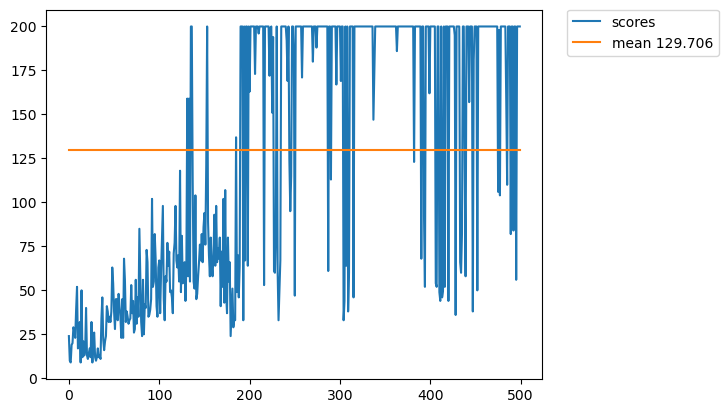

In [77]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# Hyperparams (should be sufficient)
gamma = 1.0
epsilon = 1.0
epsilon_min = 0.001
epsilon_decay = 0.0005
alpha = 0.001
batch_size = 32

model = build_model(state_size=state_size, action_size=action_size, alpha=alpha)

agent = AdvancedQAgent(action_size=action_size, state_size=state_size, model=model, batch_size=batch_size, 
                       gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min)

statistics = interact_with_environment(env, agent, n_episodes=500, verbose=True)
env.close()
plot_statistics(statistics)

Der `AdvancedQAgent` sollte nun trainierbar sein und im Plot der Scores (über etwa 500 Episoden) sollte man einen Aufwärtstrend ab etwa Episode 200 erkennen. Trotz gut gewählter Hyperparameter wird der Agent jedoch ziemlich instabil sein, mit Scores die zwar immer wieder die 200 erreichen, zwischendurch jedoch häufig bis auf einstellige Werte zurückfallen. Der erreichte Score beim CartPole wird auch nach 500 Episoden noch stark schwanken. Diese Instabilität gilt es im nächsten Schritt zu beheben.

Mit dem `AdvancedQAgent` wurde zwar praktisch ein Deep Q-Learning Agent eingeführt, dieser ist jedoch leider nicht zu gebrauchen. Vor diesem Problem standen auch die Leute von DeepMind 2013 bzw. 2015, infolgedessen DQN erschaffen wurde. Deep Q-Network (DQN) machte als erster Algorithmus die Verwendung von neuronalen Netzen im Reinforcement Learning Bereich nutzbar. Die oben erfahrenen Instabilitäten wurden dabei mittels Replay Memory und Target Network angegangen. An dieser Stelle soll nun entsprechend der `AdvancedQAgent` um genau diese Fähigkeiten erweitert werden.

In Aufgabe 3.2 wird das DQN CartPole angewendet, dies ist hauptsächlich als zusätzlicher Verständnisschritt gedacht. In Aufgabe 4 wird ebenfalls das DQN angewendet, allerdings dann auf Atari Pong. Daher kann Aufgabe 3.2 auch überprungen werden und ist als optional anzusehen.

### Aufgabe 3.2: DQN mit CartPole (optional)
Für den `DQNAgent` wird nun in der `__init__` Methode ein zusätzliches Target Network angelegt, welches es in regelmäßigen Abständen mit den Gewichten aus dem anderen Netzwerk zu aktualisieren gilt. Der Replay Memory (`memory`) soll nun nicht mehr nur als Mini-Batch Zwischenspeicher dienen, sondern eine größere Ansammlung an States enthalten, über welche zufällig gesampled werden kann, um Korrelationen von sequentiellen States aufzubrechen und damit das Training zu stabilisieren.

An dem Model wird nichts verändert.

In [9]:
class DQNAgent(AbstractAgent):

    def __init__(self, action_size: int, state_size: int, model: Model, target_model: Model, batch_size: int, 
                 gamma: float, epsilon: float, epsilon_decay: float, epsilon_min: float, 
                 start_replay_step: int, target_model_update_interval: int):
        self.action_size = action_size
        self.state_size = state_size
        
        self.gamma = gamma # discount factor (how much discount future reward)
        self.epsilon = epsilon # initial exploration rate of the agent (exploitation vs. exploration)
        self.epsilon_min = epsilon_min # minimal epsilon: x% of the time take random action
        self.epsilon_decay = epsilon_decay # decay epsilon over time to shift from exploration to exploitation
        
        # Remembered states and rewards which are used for learning in mini-batch volumes
        self.memory = deque(maxlen=memory_size)
        
        self.model = model
        self.target_model = target_model
        self.batch_size = batch_size # can be any multiple of 32 (smaller mini-batch size usually leads to higher accuracy)
        
        self.step = 0 # number of steps played
        
        self.start_replay_step = start_replay_step # After how many played steps the experience replay should start
        self.target_model_update_interval = target_model_update_interval # After how many steps should the weights of the target model be updated

        assert self.start_replay_step >= self.batch_size, \
            "The number of steps to start replay must be at least as large as the batch size"

        self.action_mask = np.ones((1, self.action_size))
        self.action_mask_batch = np.ones((self.batch_size, self.action_size))

    def _replay(self) -> None:
        """Sample random over collected experiences from memory for batch update of Q-function.
        
        Returns:
            None
        """
        # TODO: Get a random mini-batch from memory and create numpy arrays for each part of this experience
        states, actions, next_states, rewards, dones = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

        # The following assert statements are intended to support further implementation,
        # but can also be removed/adjusted if necessary.
        assert all(isinstance(x, np.ndarray) for x in (states, actions, rewards, next_states, dones)), \
            "All experience batches should be of type np.ndarray."
        assert states.shape == (self.batch_size, self.state_size), \
            f"States shape should be: {(self.batch_size, self.state_size)}"
        assert actions.shape == (self.batch_size,), f"Actions shape should be: {(self.batch_size,)}"
        assert rewards.shape == (self.batch_size,), f"Rewards shape should be: {(self.batch_size,)}"
        assert next_states.shape == (self.batch_size, self.state_size), \
            f"Next states shape should be: {(self.batch_size, self.state_size)}"
        assert dones.shape == (self.batch_size,), f"Dones shape should be: {(self.batch_size,)}"

        # TODO: Predict the Q values of the next states. Passing ones as the action mask
        next_q_values = None

        # TODO: Set the Q values of terminal states to 0 (by definition)

        # TODO: Calculate the Q values, remember the Q values of each non-terminal state is the reward + gamma * the max next state Q value
        # Depending on the implementation, the axis must be specified to get the max Q value for EACH batch element!
        q_values = None

        # TODO: Create a one hot encoding of the actions (the selected action is 1 all others 0)
        one_hot_actions = None

        # TODO: Create the target Q values based on the one hot encoding of the actions and the calculated Q values
        target_q_values = None

        # TODO: Fit the model with the right x and y values
        #self.model.fit(
        #    x=None,  # states and mask
        #    y=None,  # target Q values
        #    batch_size=self.batch_size,
        #    verbose=0
        #)

    def act(self, state: np.ndarray) -> int:
        """Selects the action to be executed based on the given state.

        Implements epsilon greedy exploration strategy, i.e. with a probability of
        epsilon, a random action is selected.

        Args:
            state [array]: Numpy array with shape (1,4) representing the state based on 4 float values:
                - cart position,
                - cart velocity,
                - angle,
                - angle velocity

        Returns:
            action [int]
        """
        if np.random.rand() <= self.epsilon:
            # TODO: Return random valid action
            action = 0
        else:
            # TODO: Use the model to get the Q values for the state and determine the action based on the max Q value
            action = 1
        return action

    def train(self, experience: Tuple[np.ndarray, int, np.ndarray, float, bool]) -> None:
        """Stores the experience in memory. If memory is full trains network by replay.

        Args:
            experience [tuple]: Tuple of state, action, next state, reward, done.

        Returns:
            None
        """
        self.memory.append(experience)

        # TODO: As soon as enough steps are played:
        #  - Update epsilon as long as it above threshold
        #  - Update weights of the target model (syn of the two models)
        #  - Execute replay

        self.step += 1

In [ ]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# Hyperparams (should be sufficient)
gamma = 1.0
epsilon = 1.0
epsilon_min = 0.001
epsilon_decay = 0.0005
alpha = 0.001
batch_size = 32
memory_size = 50000
start_replay_step = 2000
target_model_update_interval = 1000

model = build_model(state_size=state_size, action_size=action_size, alpha=alpha)
target_model = build_model(state_size=state_size, action_size=action_size, alpha=alpha)

agent = DQNAgent(action_size=action_size, state_size=state_size, model=model, target_model=target_model, batch_size=batch_size, 
                 gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, 
                 start_replay_step=start_replay_step, target_model_update_interval=target_model_update_interval)

statistics = interact_with_environment(env, agent, n_episodes=500, verbose=True)
env.close()
plot_statistics(statistics)

In [ ]:
assert len(statistics) >= 100, 'Please run at least 100 episodes for validating result'
print('Mean over last 100 episodes: {}'.format(np.mean(list(map(itemgetter('score'), statistics[-100:])))))
check_test.run_check('mean_score_check', statistics)

#### Performanceauswertung (Video)

Der folgende Code dient zur Performancebewertung des Agenten. Der (hoffentlich) trainierte Agent wird bei seiner Ausführung gefilmt, trainiert aber nicht weiter. Anschließend wird das Video seiner besten Performance dargestellt.

In [ ]:
for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()